# Welcome to CS 5242 **Homework 2**

ASSIGNMENT DEADLINE ⏰ : **05 Sept 2022** 

In this assignment, the task is to implement Multi-Layer Perceptron (MLP) for handwritten digit classification from scratch.

Colab is a hosted Jupyter notebook service that requires no setup to use, while providing access free of charge to computing resources including GPUs. In this semester, we will use Colab to run our experiments.

> In this assignment, there is no need to use GPU.

### **Grades Policy**

We have 10 points for this homework. 15% off per day late, 0 scores if you submit it 7 days after the deadline.

### **Cautions**

**DO NOT** use external libraries like PyTorch or TensorFlow in your implementation.

**DO NOT** copy the code from the internet, e.g. GitHub.

---

### **Contact**

Please feel free to contact us if you have any question about this homework or need any further information.

Slack (Recommend): Shenggan Cheng

TA Email: shenggan@comp.nus.edu.sg

> If you have not join the slack group, you can click [here](https://join.slack.com/t/cs5242ay20222-oiw1784/shared_invite/zt-1eiv24k1t-0J9EI7vz3uQmAHa68qU0aw)

## Setup

Start by running the cell below to set up all required software.

In [ ]:
!pip install numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download and extract MNIST Dataset.

In [ ]:
!mkdir -p data \
    && wget -q https://raw.githubusercontent.com/Shenggan/cs5242_resource/main/homework2/mnist_data.tar.gz -O ./data/mnist_data.tar.gz \
    && tar xf data/mnist_data.tar.gz -C ./data \
    && rm -rf ./data/mnist_data.tar.gz \
    && ls -l ./data/

total 124872
-rw-r--r-- 1 1000 1000  18289443 Jul 15  2019 mnist_test.csv
-rw-r--r-- 1 1000 1000 109575994 Jul 15  2019 mnist_train.csv


Import the neccesary library.

In [ ]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Everything is ready, you can move on and ***Good Luck !*** 😃

## Explore MNIST Dataset

One of the first steps when working with a new data set is exploring.Our data here is from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of `28x28` pixel images of handwritten digits from `0-9`, which has an important place in the history of machine learning.

Our data have been downloaded in the directory `data`: `mnist_train.csv` and `mnist_test.csv`, so the complete file path (from the main directory) are `data/mnist_train.csv` and `data/mnist_test.csv`. 

With that in mind, let's define a helper function `load_data` that we can use to quickly in our data.


In [ ]:
def load_data(dir_name):
    """
    Function for loading MNIST data stored in comma delimited files. Labels for 
    each image are the first entry in each row.

    Parameters
    ----------
    dit_name : str
         Path to where data is contained

    Returns
    -------
    X : np.array, np.float32
        A (N x 784) matrix of samples
    Y : np.array, np.float32
        A (N x 1) matrix of labels for each sample
    """
    X, Y = None, None

    # Hint:
    # 1) open the file and iterate through each line
    # 2) in every line, split with ',' and you can get 785 elements
    # 3) as the first number in each sample is the label (0-9), extract that from the rest and return

    # Some numpy function you maybe need to use: `np.array`, `numpy.ndarray.astype`, `numpy.asarray`
    # A kindly example, 
    # tmp_str = "1,2,3,4"
    # array = np.array(line.split(',')).astype(np.float32)
    # print(array)

    # === Complete the code (1')
    with open(dir_name) as f:
      items = np.array([line.split(',') for line in f]).astype(np.float32)
    X, Y = items[:,1:], items[:,0]
    # === Complete the code
    return X, Y
  

In [ ]:
X_train, Y_train = load_data("./data/mnist_train.csv")
X_test, Y_test = load_data("./data/mnist_test.csv")

An easy to quickly get an idea for how your data looks is to examine the shape of the matrix it's stored using the `.shape` attribute of numpy arrays. We see that the shape of `X_train` is `60000 x 784`, which tells us there are `60000` samples (images) each with dimension `784`. Each sample, typically presented as a 28 x 28 image, is unrolled into a 1-dimensional vector 28 x 28 = 784 contained within each row of `X_train`.

In [ ]:
print(f"The shape of the training set is: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"The shape of the test set is: {X_test.shape[0]} x {X_test.shape[1]}")

The shape of the training set is: 60000 x 784
The shape of the test set is: 10000 x 784


Now lets take a look at how the samples are represented, we can do this by calling `Y_train[index]` and `X_train[index]` (here I choose `index=0` to look at the very first sample). We first notice `Y_train[0]=5.0`, meaning this entry is the digit `5`. We will confirm this shortly by visualizing some of these samples. We then notice each entry is an integer (cast into `np.float32` in our `load_data` function) ranging from `0-255`. This representation is common when working with images. The numerical entries are interpreted as pixel intensities typically shown in gray-scale ranging between `0` (black) and `255` (white). 

In [ ]:
index = 0
print(f"Y_train[{index}]: {Y_train[index]}")
print(f"X_train[{index}] range from {min(X_train[index])} to {max(X_train[index])}.")

Y_train[0]: 5.0
X_train[0] range from 0.0 to 255.0.


In [ ]:
# rescale data between 0 - 1.0
def scale_data(X):
    X_scaled = None
    # === Complete the code (0.5')
    X_scaled = (X - np.min(X))/(np.max(X)-np.min(X))
    # === Complete the code
    return X_scaled

X_train = scale_data(X_train)
X_test = scale_data(X_test)

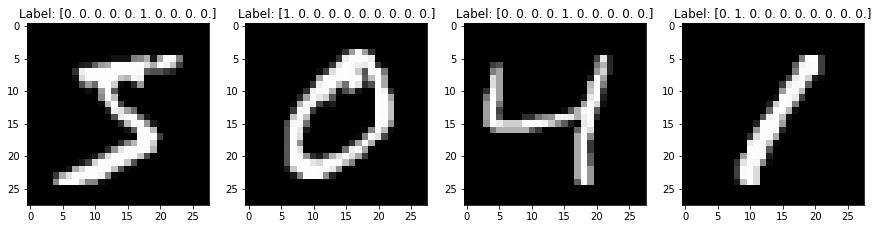

In [ ]:
y_train_onehot = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_test_onehot = np.zeros((Y_test.size, int(Y_test.max()) + 1))

# one-hot encode train (y_train) and test (y_test) set labels
# === Complete the code (0.5')
y_train_onehot[np.arange(Y_train.size), Y_train.astype(int)] = 1
y_test_onehot[np.arange(Y_test.size), Y_test.astype(int)] = 1
# === Complete the code

num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for image, label, ax in zip(X_train[:num_images], y_train_onehot[:num_images], axes):
    ax.imshow(image.reshape(28, 28), cmap='gray', vmin=0, vmax=1.0)
    ax.set_title(f"Label: {label}")

## Implementation of Multilayer perceptron

We'll first go through and write the code for each piece of an MLP (**without bias**) in generic Python functions. We'll then wrap everything in an `MLP` class, which will allow us to easily access all the MLP functionality in a user friendly manner.

### Feed Forward

Implementing the forward pass of the neural network is relatively simply as everything is basically just a series of matrix multiplicaitons and activation functions. A two-layer MLP example we looked at when working through the math had a forward pass which mathematically took the form:
$$\sigma(\mathbf{x}W^{(1)})W^{(2)}$$

We'll of course want to make things a bit more modular by allowing the user to choose some of the neural network paramters, such as the number of hidden layers `L` and the nunber of neurons per layer `N_l`. For simplicity we'll restrict that all the hidden layers are treated with **sigmoid** activaitons.

The last step of process for classification tasks is actually producing a prediction from these numbers in the output layer. Typically, in the case of multi-label classification, this is done using a *softmax* activation function which effectively converts the output neurons into probabilities for each label. This has the mathematical form, $$\text{softmax}(\mathbf{z})_j = \frac{\exp(z_j)}{\sum_{k=0}^{K=9}\exp{(z_k)}}$$.

The softmax activation function has the property of the outputs summing to 1 $\sum_{k=1}^{K=9}\text{softmax}(\mathbf{z}^{(2)})_k = 1$, allowing each output $\mathbf{a}^{(2)}_i = \text{softmax}(\mathbf{z}^{(2)})_i$ to be interpreted as the probability that the input is actually a digit `0-9`. Note, the output of a MLP does not need to have a softmax activation, for example in a regression setting a softmax activation would not make much sense. When evaluating the classification accuracy of the neural network, the input is typically classified according to the output label with the highest probability, 

$$\text{prediction}(\mathbf{x}) = \text{argmax}\  \text{softmax}(\mathbf{z}^{(2)}) = \text{argmax}\  \text{softmax}((\sigma(\mathbf{x}W^{(1)})W^{(2)}))$$.

We can start by simply defining our activation functions:

In [ ]:
def sigmoid(x):
    """
    Compute the sigmoid of `x`, calculated element-wise

    Parameters
    ----------
    x : float or array_like
        input

    Returns
    -------
    sigmoid(x) : float or array_like
        sigmoid applied to `x` element-wise
    """
    result = None
    # === Complete the code (0.5')
    result = 1.0/(1.0 + np.exp(-x))
    # === Complete the code
    return result

In [ ]:
def softmax(x):
    """
    Compute the softmax of `x`,

    Parameters
    ----------
    x : array_like
        (N x dim) array with N samples by p dimensions. dim=10 for MNIST classification. 

    Returns
    -------
    softmax(x) : float or array_like
        softmax applied to `x` along the first axis.
    """
    result = None
    # === Complete the code (0.5')
    result = np.exp(x)/np.exp(x).sum(axis=1, keepdims=True)
    # === Complete the code
    return result

The inputs `x`, weight matricies `w`, and activations are in principle all we need to define the forward pass; however, for efficency reasons we'll want to store the outputs of the hidden layer neurons when performing the forward pass. Storing these values will help us later more quickly calculate the gradients during the backward pass. The `init_layers` functions will initalize these hidden layers as NumPy arrays, doing this before we begin training will help us save some overhead we would otherwise inccur reinitalizing these hidden layers before each forward pass. These hidden layer values will be stored in multi-dimensional matricies, called *tensors*. One dimension of these tensors will be the `batch size` which will indicate the number of samples simultaneously passed to MLP during one training loop (feed forward + backpropagation).

In [ ]:
def init_layers(batch_size, layer_sizes):
    """
    Initalize arrays to store the hidden layer ouputs.

    Parameters
    ----------
    batch_size : int
        Number of samples to concurrently feed through the network.
    layer_sizes : array_like
        Array of length `N_l`. Each entry is the number of neurons in each layer.

    Returns
    -------
    hidden_layers : list
        List of empty arrays used to hold hidden layer outputs. 
    """
    hidden_layers = [np.empty((batch_size, layer_size)) for layer_size in layer_sizes]
    return hidden_layers

In order to perform a forward pass our input `x` is consequtively multiplied by weight matricies passed into the associated activaiton functions. The paramters in these weight matricies will ultimately be learned through backpropagation, but each weight matrix must first be initalized to random values. There are a number of different methods for doing this initalization, but for the moment we'll use a simple approach of just drawing the numerical values from a normal distribution with mean zero and standard deviation 1. We could have also reasonably choosen to simply draw from a uniform distribution on the range `[-1,1]`. 

In [ ]:
def init_weights(layer_sizes):
    """
    Initalize the paramters of the weight matricies.

    Parameters
    ----------
    layer_sizes : array_like
        Array of length `N_l`. Each entry is the number of neurons in each layer.

    Returns
    -------
    weights : array_like
        Randomly initalized weight matricies based on the layer sizes. 
    """
    weights = list()
    for i in range(layer_sizes.shape[0] - 1):
        weights.append(np.random.uniform(-1, 1, size=[layer_sizes[i], layer_sizes[i + 1]]))
    return weights

### Backpropagation

Initalizing all the weights, layers, and activations prior to the forward pass makes much of the backward pass implimentation actually quite simple. For convinience we'll define a `sigmoid_derivative` function, which simply computes the derivative of the sigmoid activation $\sigma^{\prime}$. We'll use this when computing the gradients during the backward pass.

In [ ]:
def sigmoid_derivative(sigmoid_out):
    """
    Calculate derivative of sigmoid activation based on sigmoid output.

    Parameters
    ----------
    sigmoid_out : array_like
        Output values processed by a sigmoid function.
    
    Returns
    -------
    sigmoid_derivative(h) : array_like
        Derivative of sigmoid, based on value of sigmoid.
    """
    result = None
    # === Complete the code (0.5')
    result = sigmoid_out * (1.0- sigmoid_out)
    # === Complete the code
    return result

### Training

You have **three tasks** in this section.

1. You need to implement `__feed_forward` function.
2. You need to implement `__back_prop` function.
3. You need to implement the main loop of `train` function.

In [33]:
def to_categorical(x, class_num):
    # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
    categorical = np.zeros((x.shape[0], class_num))
    categorical[np.arange(x.shape[0]), x.argmax(axis=1)] = 1
    return categorical

def accuracy(y_pred, y):
    # Compute the accuracy along the rows, averaging along the number of samples
    return np.all(y_pred == y, axis=1).mean()

def loss(y_pred, y):
    # Compute the loss along the rows, averaging along the number of samples
    loss_ = ((-np.log(y_pred)) * y).sum(axis=1).mean()
    return loss_

class MLP():

    def __init__(self, X, Y, X_val, Y_val, L=1, N_l=128):
        self.X = X
        self.Y = np.squeeze(np.eye(10)[Y.astype(int).reshape(-1)])
        self.X_val = X_val
        self.Y_val = np.squeeze(np.eye(10)[Y_val.astype(int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]] + [N_l] * L + [self.Y.shape[1]])
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [
            self.train_loss, self.train_acc, self.val_loss, self.val_acc, self.train_time,
            self.tot_time
        ]

        self.class_num = self.Y.shape[1]

    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = list()
        for i in range(self.layer_sizes.shape[0] - 1):
            self.weights.append(
                np.random.uniform(-1, 1, size=[self.layer_sizes[i], self.layer_sizes[i + 1]]))
        self.weights = np.asarray(self.weights)

    def __init_layers(self, batch_size):
        # Initialize and allocate arrays for the hidden layer activations
        self.__h = [np.empty((batch_size, layer)) for layer in self.layer_sizes]

    def __feed_forward(self, batch):
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        out_ = None
        h_l = batch
        self.__h[0] = h_l
        # === Complete the code (1.5')
        for step in range(len(self.weights)):
           temp_h = np.dot(self.__h[step], self.weights[step])
           self.__h[step+1] = sigmoid(temp_h) if (step != len(self.weights) - 1) else softmax(temp_h)
        out_ = self.__h[len(self.weights)]
        # === Complete the code
        self.__out = out_

    def __back_prop(self, batch_y):
        # Update the weights of the network through back-propagation
        # === Complete the code (1.5')
        delta = (self.__out - batch_y)
        for i in range(len(self.weights)-1, -1, -1):
          self.weights[i] = self.weights[i] - self.lr*np.dot(self.__h[i].T, delta)/self.batch_size
          delta = sigmoid_derivative(self.__h[i])*np.dot(delta, self.weights[i].T)
        # === Complete the code

    def predict(self, X):
        # Generate a categorical, one-hot, prediction given an input X
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return to_categorical(self.__out, self.class_num)

    def evaluate(self, X, Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction = self.predict(X)
        return accuracy(prediction, Y)

    def train(self, batch_size=8, epochs=25, lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size = batch_size
        for epoch in range(epochs):
            start = time.time()

            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle], self.n_samples / self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle], self.n_samples / self.batch_size)
            for batch_x, batch_y in zip(X_batches, Y_batches):
                # === Complete the code (1.5')
                self.__feed_forward(batch_x)
                self.__back_prop(batch_y)
                train_loss = train_loss + loss(self.__out, batch_y)
                train_acc = train_acc + accuracy(to_categorical(self.__out, self.class_num), batch_y)
                # === Complete the code
            train_loss = (train_loss / len(X_batches))
            train_acc = (train_acc / len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)

            train_time = round(time.time() - start, 3)
            self.train_time.append(train_time)

            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = loss(self.__out, self.Y_val)
            val_acc = accuracy(to_categorical(self.__out, self.class_num), self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)

            tot_time = round(time.time() - start, 3)
            self.tot_time.append(tot_time)

            print(
                f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}"
            )


Great, now let's give this a try. Let's create a really simple MLP with only a single hidden layer `L=2` with 64 neurons `N_l=64`. We'll train with a `batch_size=8` for `epochs=20` and a learning rate `lr=0.2`.

In [34]:
model = MLP(X_train, Y_train, X_test, Y_test, L=2, N_l=64)
model.train(batch_size=8, epochs=20, lr=0.2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1: loss = 0.415 | acc = 0.871 | val_loss = 0.219 | val_acc = 0.932 | train_time = 9.696 | tot_time = 9.962
Epoch 2: loss = 0.209 | acc = 0.937 | val_loss = 0.169 | val_acc = 0.947 | train_time = 13.47 | tot_time = 13.619
Epoch 3: loss = 0.161 | acc = 0.951 | val_loss = 0.158 | val_acc = 0.954 | train_time = 8.865 | tot_time = 9.002
Epoch 4: loss = 0.131 | acc = 0.961 | val_loss = 0.145 | val_acc = 0.957 | train_time = 10.489 | tot_time = 10.628
Epoch 5: loss = 0.111 | acc = 0.966 | val_loss = 0.14 | val_acc = 0.959 | train_time = 9.254 | tot_time = 9.391
Epoch 6: loss = 0.097 | acc = 0.971 | val_loss = 0.134 | val_acc = 0.96 | train_time = 8.617 | tot_time = 8.748
Epoch 7: loss = 0.087 | acc = 0.973 | val_loss = 0.151 | val_acc = 0.956 | train_time = 8.529 | tot_time = 8.656
Epoch 8: loss = 0.076 | acc = 0.976 | val_loss = 0.132 | val_acc = 0.961 | train_time = 10.288 | tot_time = 10.421
Epoch 9: loss = 0.067 | acc = 0.98 | val_loss = 0.123 | val_acc = 0.967 | train_time = 9.868 

Text(0, 0.5, 'Accuracy')

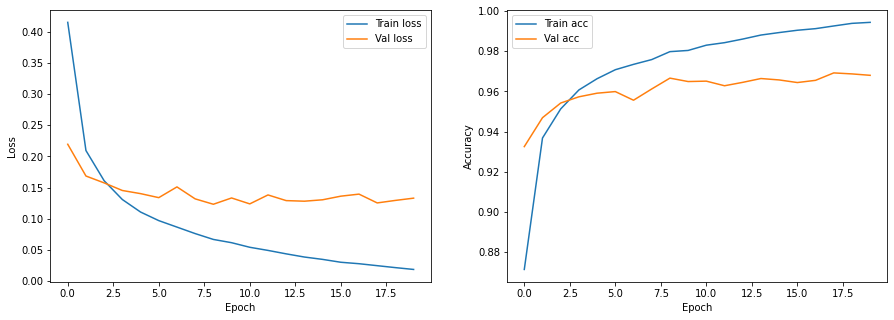

In [35]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")

## Discussion (2 points)

In this section, you are free to choose some of the following directions to explore, and try to summarize some patterns and conclusions.

* Try to use different learning rates and generalize the impact of learning rate on training.
* Try to use different number of layers of MLPs or different number of neurons of MLPs (including different ways of weight initialization) and explore the impact on the final classification performance.
* Try to use a portion of the data for training (e.g., 10%, 20%, 50%) to explore the training convergence and final classification performance with different amounts of data.

> **NOTE:** *Good Disscusion* include experimental setup, presentation of experimental results including visualization, analysis and interpretation of phenomena, and summary of conclusions

* We create a modifed MLP Class for experiment that allows for custom customs for weight initlizations.

* Each experiment contains its own results along with anaylsis and visualization (if appropriate).



In [36]:
# === Complete the code (2')
class MLP_Experiment():

    def __init__(self, X, Y, X_val, Y_val, weight_func, L=1, N_l=128, init_range=[-1, 1]):
        self.X = X
        self.Y = np.squeeze(np.eye(10)[Y.astype(int).reshape(-1)])
        self.X_val = X_val
        self.Y_val = np.squeeze(np.eye(10)[Y_val.astype(int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.weight_func = weight_func
        self.init_range = init_range
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]] + [N_l] * L + [self.Y.shape[1]])
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [
            self.train_loss, self.train_acc, self.val_loss, self.val_acc, self.train_time,
            self.tot_time
        ]

        self.class_num = self.Y.shape[1]

    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = list()
        for i in range(self.layer_sizes.shape[0] - 1):
          weights = None
          if(self.weight_func == 'xavier'):
            weights = np.random.uniform(-1.0/np.sqrt(self.layer_sizes[i]), 1.0/np.sqrt(self.layer_sizes[i]), size=[self.layer_sizes[i], self.layer_sizes[i + 1]])  
          elif(self.weight_func=='gaussian'):
            weights = np.random.normal(0, np.sqrt(2/self.layer_sizes[i]), size=[self.layer_sizes[i], self.layer_sizes[i + 1]])
          elif(self.weight_func.__name__=='uniform'):
            weights = self.weight_func(self.init_range[0], self.init_range[1], size=[self.layer_sizes[i], self.layer_sizes[i + 1]])  
          else:
            weights = self.weight_func(size=[self.layer_sizes[i], self.layer_sizes[i + 1]]) 
          self.weights.append(weights)
        self.weights = np.asarray(self.weights)

    def __init_layers(self, batch_size):
        # Initialize and allocate arrays for the hidden layer activations
        self.__h = [np.empty((batch_size, layer)) for layer in self.layer_sizes]

    def __feed_forward(self, batch):
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        out_ = None
        h_l = batch
        self.__h[0] = h_l
        # === Complete the code (1.5')
        for step in range(len(self.weights)):
           temp_h = np.dot(self.__h[step], self.weights[step])
           self.__h[step+1] = sigmoid(temp_h) if (step != len(self.weights) - 1) else softmax(temp_h)
        out_ = self.__h[len(self.weights)]
        # === Complete the code
        self.__out = out_

    def __back_prop(self, batch_y):
        # Update the weights of the network through back-propagation
        # === Complete the code (1.5')
        delta = (self.__out - batch_y)
        for i in range(len(self.weights)-1, -1, -1):
          self.weights[i] = self.weights[i] - self.lr*np.dot(self.__h[i].T, delta)/self.batch_size
          delta = sigmoid_derivative(self.__h[i])*np.dot(delta, self.weights[i].T)
        # === Complete the code

    def predict(self, X):
        # Generate a categorical, one-hot, prediction given an input X
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return to_categorical(self.__out, self.class_num)

    def evaluate(self, X, Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction = self.predict(X)
        return accuracy(prediction, Y)

    def train(self, batch_size=8, epochs=25, lr=1.0):
        results = []
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size = batch_size
        for epoch in range(epochs):
            start = time.time()

            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle], self.n_samples / self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle], self.n_samples / self.batch_size)
            for batch_x, batch_y in zip(X_batches, Y_batches):
                # === Complete the code (1.5')
                self.__feed_forward(batch_x)
                self.__back_prop(batch_y)
                train_loss = train_loss + loss(self.__out, batch_y)
                train_acc = train_acc + accuracy(to_categorical(self.__out, self.class_num), batch_y)
                # === Complete the code
            train_loss = (train_loss / len(X_batches))
            train_acc = (train_acc / len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)

            train_time = round(time.time() - start, 3)
            self.train_time.append(train_time)

            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = loss(self.__out, self.Y_val)
            val_acc = accuracy(to_categorical(self.__out, self.class_num), self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)

            tot_time = round(time.time() - start, 3)
            self.tot_time.append(tot_time)

            results.append({'epoch': epoch+1, 'loss': train_loss.round(3), 'acc': train_acc.round(3), 'val_loss': val_loss.round(3), 'val_acc': val_acc.round(3), 'train_time': train_time})
        return(results)
            
# === Complete the code

### Learning Rate Experiment 

We iterate over a range of different learning rates to evaluate performance.
- We will iterate over learning rates from 0.0 to 1.0(including 0.2 as proposed in the original question) with a step size of 0.05
- The experiment will be run for a smaller number of epochs (5) to reduce complexity.
- The lowest losses and highest accuracies are taken across epochs for each learning rate to plot the graph.

NOTE: Runtime ~ 15 minutes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR: 0.00, Best Values Train_loss: 4.093,   Val_loss: 4.091,   'Train_Acc: 0.134,   'Val_Acc: 0.134
LR: 0.05, Best Values Train_loss: 0.178,   Val_loss: 0.191,   'Train_Acc: 0.947,   'Val_Acc: 0.943
LR: 0.10, Best Values Train_loss: 0.132,   Val_loss: 0.154,   'Train_Acc: 0.96,   'Val_Acc: 0.951
LR: 0.15, Best Values Train_loss: 0.114,   Val_loss: 0.142,   'Train_Acc: 0.965,   'Val_Acc: 0.955
LR: 0.20, Best Values Train_loss: 0.101,   Val_loss: 0.144,   'Train_Acc: 0.969,   'Val_Acc: 0.955
LR: 0.25, Best Values Train_loss: 0.109,   Val_loss: 0.144,   'Train_Acc: 0.966,   'Val_Acc: 0.958
LR: 0.30, Best Values Train_loss: 0.106,   Val_loss: 0.137,   'Train_Acc: 0.967,   'Val_Acc: 0.96
LR: 0.35, Best Values Train_loss: 0.122,   Val_loss: 0.148,   'Train_Acc: 0.963,   'Val_Acc: 0.962
LR: 0.40, Best Values Train_loss: 0.15,   Val_loss: 0.215,   'Train_Acc: 0.958,   'Val_Acc: 0.939
LR: 0.45, Best Values Train_loss: 0.195,   Val_loss: 0.237,   'Train_Acc: 0.95,   'Val_Acc: 0.941
LR: 0.50, Best

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


LR: 0.85, Best Values Train_loss: 2.91,   Val_loss: 1.732,   'Train_Acc: 0.666,   'Val_Acc: 0.775
LR: 0.90, Best Values Train_loss: 3.52,   Val_loss: 2.651,   'Train_Acc: 0.648,   'Val_Acc: 0.696
LR: 0.95, Best Values Train_loss: 6.663,   Val_loss: 4.338,   'Train_Acc: 0.474,   'Val_Acc: 0.552


Text(0, 0.5, 'Accuracy')

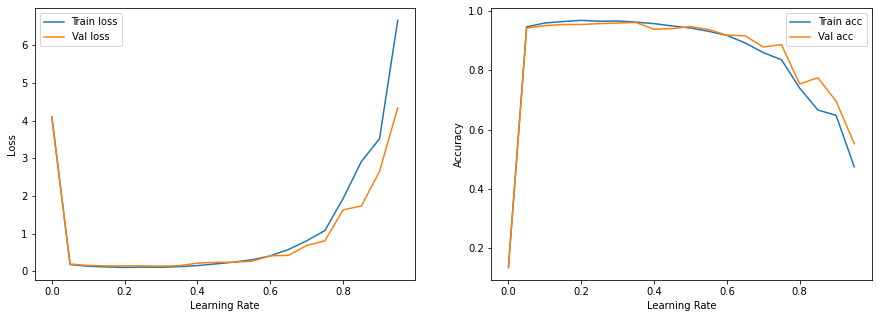

In [38]:
lr_range = np.arange(0.0, 1.0, 0.05)
train_losses = []
val_losses = []
train_accs = []
val_accs = []
for lr in lr_range:
  model = MLP_Experiment(X_train, Y_train, X_test, Y_test, np.random.uniform, L=2, N_l=64)
  res = model.train(batch_size=8, epochs=5, lr=lr)
  train_losses.append(min(res, key=lambda x:x['loss'])['loss'])
  val_losses.append(min(res, key=lambda x:x['val_loss'])['val_loss'])
  train_accs.append(max(res, key=lambda x: x['acc'])['acc'])
  val_accs.append(max(res, key=lambda x: x['val_acc'])['val_acc'])
  print(f"LR: {lr:.2f}, Best Values Train_loss: {min(res, key=lambda x:x['loss'])['loss']}, \
  Val_loss: {min(res, key=lambda x:x['val_loss'])['val_loss']}, \
  'Train_Acc: {max(res, key=lambda x: x['acc'])['acc']}, \
  'Val_Acc: {max(res, key=lambda x: x['val_acc'])['val_acc']}")
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(lr_range, train_losses,label="Train loss")
ax[0].plot(lr_range, val_losses,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Learning Rate")
ax[0].set_ylabel("Loss")

ax[1].plot(lr_range, train_accs,label="Train acc")
ax[1].plot(lr_range, val_accs,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Learning Rate")
ax[1].set_ylabel("Accuracy")

* We can see that beyond a certain value of learning rate (0.30 in this case), the loss starts to increase exponentially and similarly the accuracy decreases.
* It is possible that the gradient descent stops converging beyond this point for our case and hence large values should not be considered. 
* Moreover, it is also likely that the divergence has not started and its only the convergence that has slowed down. But the general increase of loss for values of learning rate > 0.3 indicates that for a relatively large value, the gradient descent would start to diverge too.
* The lowest losses and highest accuracies are seen for learning rates 0.2 and 0.3 which should be the ones selected for the experiment.

### Neural Network Complexity Experiment

* We run experiments over Neural Network complexity by iterating over values for the number of layers and the number of neurons in every layer, using the same MNIST dataset.
* Values from [0,3] inclusive are used as the range for the number of layers.
* Values of [4, 14, 49, 64, 112] are used to test the number of neurons based on the original value of 64 and some factorizations of the number of features (784)

NOTE: Runtime ~10 minutes

#Layers: 0 #Nodes/Layer:4, Best Values Train_loss: 0.349,     Val_loss: 0.351,     'Train_Acc: 0.907,     'Val_Acc: 0.909
#Layers: 0 #Nodes/Layer:14, Best Values Train_loss: 0.349,     Val_loss: 0.347,     'Train_Acc: 0.907,     'Val_Acc: 0.911
#Layers: 0 #Nodes/Layer:49, Best Values Train_loss: 0.346,     Val_loss: 0.336,     'Train_Acc: 0.908,     'Val_Acc: 0.914
#Layers: 0 #Nodes/Layer:64, Best Values Train_loss: 0.349,     Val_loss: 0.345,     'Train_Acc: 0.908,     'Val_Acc: 0.911
#Layers: 0 #Nodes/Layer:112, Best Values Train_loss: 0.347,     Val_loss: 0.345,     'Train_Acc: 0.909,     'Val_Acc: 0.909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#Layers: 1 #Nodes/Layer:4, Best Values Train_loss: 0.681,     Val_loss: 0.668,     'Train_Acc: 0.814,     'Val_Acc: 0.823
#Layers: 1 #Nodes/Layer:14, Best Values Train_loss: 0.227,     Val_loss: 0.236,     'Train_Acc: 0.933,     'Val_Acc: 0.931
#Layers: 1 #Nodes/Layer:49, Best Values Train_loss: 0.127,     Val_loss: 0.149,     'Train_Acc: 0.962,     'Val_Acc: 0.956
#Layers: 1 #Nodes/Layer:64, Best Values Train_loss: 0.115,     Val_loss: 0.149,     'Train_Acc: 0.965,     'Val_Acc: 0.956
#Layers: 1 #Nodes/Layer:112, Best Values Train_loss: 0.091,     Val_loss: 0.13,     'Train_Acc: 0.972,     'Val_Acc: 0.963
#Layers: 2 #Nodes/Layer:4, Best Values Train_loss: 0.842,     Val_loss: 0.813,     'Train_Acc: 0.69,     'Val_Acc: 0.724
#Layers: 2 #Nodes/Layer:14, Best Values Train_loss: 0.238,     Val_loss: 0.253,     'Train_Acc: 0.932,     'Val_Acc: 0.926
#Layers: 2 #Nodes/Layer:49, Best Values Train_loss: 0.115,     Val_loss: 0.161,     'Train_Acc: 0.965,     'Val_Acc: 0.951
#Layers: 2 #Nodes/L

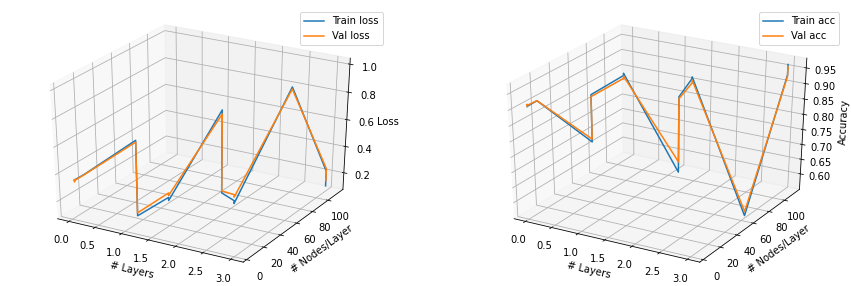

In [39]:
layers = range(4)
neurons = [4, 14, 49, 64, 112]
train_losses = []
val_losses = []
train_accs = []
val_accs = []
for layer in layers:
  for neuron in neurons:
    model = MLP_Experiment(X_train, Y_train, X_test, Y_test, np.random.uniform, L=layer, N_l=neuron)
    res = model.train(batch_size=8, epochs=5, lr=0.2)
    train_losses.append(min(res, key=lambda x:x['loss'])['loss'])
    val_losses.append(min(res, key=lambda x:x['val_loss'])['val_loss'])
    train_accs.append(max(res, key=lambda x: x['acc'])['acc'])
    val_accs.append(max(res, key=lambda x: x['val_acc'])['val_acc'])
    print(f"#Layers: {layer} #Nodes/Layer:{neuron}, Best Values Train_loss: {min(res, key=lambda x:x['loss'])['loss']}, \
    Val_loss: {min(res, key=lambda x:x['val_loss'])['val_loss']}, \
    'Train_Acc: {max(res, key=lambda x: x['acc'])['acc']}, \
    'Val_Acc: {max(res, key=lambda x: x['val_acc'])['val_acc']}")
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')]
ax[0].plot3D(np.repeat(layers, 5), np.repeat(neurons, 4), train_losses,label="Train loss")
ax[0].plot3D(np.repeat(layers, 5), np.repeat(neurons, 4), val_losses,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("# Layers")
ax[0].set_ylabel("# Nodes/Layer")
ax[0].set_zlabel("Loss")

ax[1].plot3D(np.repeat(layers, 5), np.repeat(neurons, 4), train_accs,label="Train acc")
ax[1].plot3D(np.repeat(layers, 5), np.repeat(neurons, 4), val_accs,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("# Layers")
ax[1].set_ylabel("# Nodes/Layer")
ax[1].set_zlabel("Accuracy")

plt.show()

Our findings are as follows:

* As we increase the number of layers, our loss increases and our accuracy goes down. While more layers might be preferred for some more convoluted cases, the MNIST dataset is relatively simple and the excessive complexity from additional layers potentially leads to overfitting thus making our model worse.
* For a given number of layers, as we increase the nodes, we are able to see improvements in loss and accuracy. Since the hidden layers act as nodes which build complex interpretations of our data, this can be increadibly useful in image classification as we model different sections or shapes within the images. Thus increasing the nodes increases accuracy and decreases loss.
* The best values for loss and accuracy can be seen at 1 or 2 layers with 112 nodes in each, which is close to the parameters we use in our model.

### Weight Initialization Experiment

* Weight initializations are run by initializing weights by different methods of random number generation, particularly the uniform distribution and the gaussian distribution.
* On the uniform distribution, we iterate over ranges of [[-0.3, 0.3], [-1, 1], [-2, 2], [0, 1], [0, 2]] to test differences of how wideness of the range affects our learning as well as polarity on only positive values does.
* Moreover, we try the Xavier weight initialization, an approach of the uniform distribution where the range is calculated by the inverse of the square root of the number of input nodes.
* The gaussian distribution is tried with the normal parameters (0, 1) as well as another approach of (0, $2/\sqrt{n}$) where n is the number of inputs nodes.

NOTE: Runtime ~6 minutes

In [41]:
weight_ranges = [[-0.3, 0.3], [-1, 1], [-2, 2], [0, 1], [0, 2]]
func_ranges = [np.random.uniform, np.random.normal, 'xavier', 'gaussian']
train_losses = []
val_losses = []
train_accs = []
val_accs = []
results = pd.DataFrame(columns=['Init_Function', 'Range', 'Train Loss', 'Val Loss', 'Train Acc', 'Val Acc'])

for func in func_ranges:
  weight_checks = weight_ranges if (func == func_ranges[0] and func.__name__ == 'uniform') else ['N/A']
  for weights in weight_checks:
    model = MLP_Experiment(X_train, Y_train, X_test, Y_test, func, L=2, N_l=64, init_range=weights)
    res = model.train(batch_size=8, epochs=5, lr=0.2)
    train_losses.append(min(res, key=lambda x:x['loss'])['loss'])
    val_losses.append(min(res, key=lambda x:x['val_loss'])['val_loss'])
    train_accs.append(max(res, key=lambda x: x['acc'])['acc'])
    val_accs.append(max(res, key=lambda x: x['val_acc'])['val_acc'])
    results = results.append({'Init_Function': (func if func_ranges.index(func) > 1 else func.__name__), 'Range': weights, 'Train Loss': train_losses[-1], 'Val Loss': val_losses[-1], 'Train Acc': train_accs[-1], 'Val Acc': val_accs[-1]}, ignore_index=True)
    print(f"Init Function: {func if func_ranges.index(func) > 1 else func.__name__} Range:{weights}, Best Values Train_loss: {min(res, key=lambda x:x['loss'])['loss']}, \
    Val_loss: {min(res, key=lambda x:x['val_loss'])['val_loss']}, \
    'Train_Acc: {max(res, key=lambda x: x['acc'])['acc']}, \
    'Val_Acc: {max(res, key=lambda x: x['val_acc'])['val_acc']}")

print(results)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Init Function: uniform Range:[-0.3, 0.3], Best Values Train_loss: 0.089,     Val_loss: 0.099,     'Train_Acc: 0.972,     'Val_Acc: 0.971
Init Function: uniform Range:[-1, 1], Best Values Train_loss: 0.107,     Val_loss: 0.137,     'Train_Acc: 0.967,     'Val_Acc: 0.959
Init Function: uniform Range:[-2, 2], Best Values Train_loss: 0.179,     Val_loss: 0.209,     'Train_Acc: 0.946,     'Val_Acc: 0.938
Init Function: uniform Range:[0, 1], Best Values Train_loss: 3.996,     Val_loss: 3.867,     'Train_Acc: 0.103,     'Val_Acc: 0.103
Init Function: uniform Range:[0, 2], Best Values Train_loss: 4.035,     Val_loss: 2.875,     'Train_Acc: 0.1,     'Val_Acc: 0.103
Init Function: normal Range:N/A, Best Values Train_loss: 0.164,     Val_loss: 0.201,     'Train_Acc: 0.951,     'Val_Acc: 0.941
Init Function: xavier Range:N/A, Best Values Train_loss: 3.991,     Val_loss: 3.376,     'Train_Acc: 0.101,     'Val_Acc: 0.114
Init Function: gaussian Range:N/A, Best Values Train_loss: 0.088,     Val_loss:

* From our results, we can see that the uniform distribution and gaussian (a variant of normal) distribution perform significantly better than the other models.
* This indicates that a dependence on the number of input nodes is not useful in generating the distribution to select our weights from.
* The choice of only non-negative values on the uniform distribution does not do well (as it makes sense intuitively as well), that only positive values would skew our predictions and lead to biased updates.
* Comparing results across positive and negative ranges on the uniform distribution, we see a best results at a narrow range of (-0.3, +0.3), and only a small decrease as we widen the range to (-2, +2). 
* This indicates that our optimal initial weights lie close to the value of 0 with both positive and negative values. This explains why the gaussian distribution performs well in this case too, as it generates values in the range (-0.25, 0.25) based on the size of the layer. In some cases, it might be better to use the Gaussian distribution when the layer size is not always known.

### Training Size Experiment

* We run experiments on varying train set sizes keeping the test size constant.
* Training set sizes are iterated from 10% to 100% of the existing complete training set (60000 rows) using a random shuffle selection of the rows.
* Other factors/parameters of the model are maintained as the same throughout the experiment.

NOTE: Runtime ~5 minutes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Training Size: 0.10, Best Values Train_loss: 0.204,   Val_loss: 0.322,   'Train_Acc: 0.937,   'Val_Acc: 0.905
Training Size: 0.20, Best Values Train_loss: 0.166,   Val_loss: 0.254,   'Train_Acc: 0.952,   'Val_Acc: 0.925
Training Size: 0.30, Best Values Train_loss: 0.132,   Val_loss: 0.211,   'Train_Acc: 0.96,   'Val_Acc: 0.939
Training Size: 0.40, Best Values Train_loss: 0.117,   Val_loss: 0.218,   'Train_Acc: 0.964,   'Val_Acc: 0.938
Training Size: 0.50, Best Values Train_loss: 0.112,   Val_loss: 0.18,   'Train_Acc: 0.965,   'Val_Acc: 0.948
Training Size: 0.60, Best Values Train_loss: 0.104,   Val_loss: 0.197,   'Train_Acc: 0.968,   'Val_Acc: 0.944
Training Size: 0.70, Best Values Train_loss: 0.09,   Val_loss: 0.159,   'Train_Acc: 0.973,   'Val_Acc: 0.955
Training Size: 0.80, Best Values Train_loss: 0.086,   Val_loss: 0.173,   'Train_Acc: 0.974,   'Val_Acc: 0.95
Training Size: 0.90, Best Values Train_loss: 0.077,   Val_loss: 0.182,   'Train_Acc: 0.976,   'Val_Acc: 0.948


Text(0, 0.5, 'Accuracy')

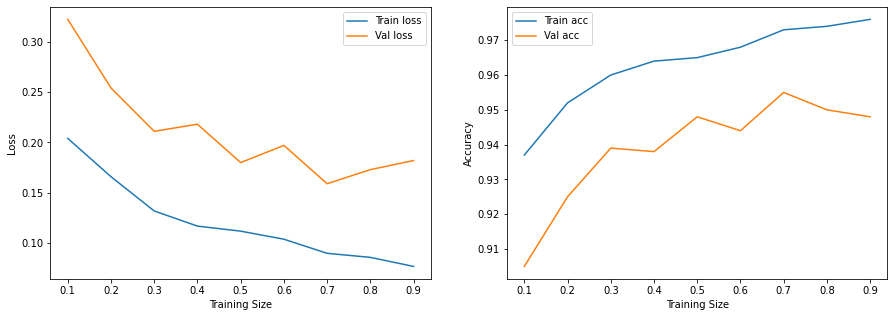

In [43]:
train_range = np.arange(0.1, 1.0, 0.1)
train_losses = []
val_losses = []
train_accs = []
val_accs = []
for train in train_range:
  sample_range = np.random.choice(len(X_train), size=int(train*len(X_train)))
  model = MLP_Experiment(X_train[sample_range], Y_train[sample_range], X_test, Y_test, np.random.uniform, L=2, N_l=64)
  res = model.train(batch_size=8, epochs=5, lr=0.2)
  train_losses.append(min(res, key=lambda x:x['loss'])['loss'])
  val_losses.append(min(res, key=lambda x:x['val_loss'])['val_loss'])
  train_accs.append(max(res, key=lambda x: x['acc'])['acc'])
  val_accs.append(max(res, key=lambda x: x['val_acc'])['val_acc'])
  print(f"Training Size: {train:.2f}, Best Values Train_loss: {min(res, key=lambda x:x['loss'])['loss']}, \
  Val_loss: {min(res, key=lambda x:x['val_loss'])['val_loss']}, \
  'Train_Acc: {max(res, key=lambda x: x['acc'])['acc']}, \
  'Val_Acc: {max(res, key=lambda x: x['val_acc'])['val_acc']}")
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(train_range, train_losses,label="Train loss")
ax[0].plot(train_range, val_losses,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Training Size")
ax[0].set_ylabel("Loss")

ax[1].plot(train_range, train_accs,label="Train acc")
ax[1].plot(train_range, val_accs,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Training Size")
ax[1].set_ylabel("Accuracy")

* We can see that as we increase the size of our training set, our model is able to improve.
* This is according to the general notion that a neural network (or any kind of machine learning model for that case) requires more data to generate more accurate predictions.
* We can see some variations of changes in loss/accuracy between sizes (i.e. for some changes in training size lead to only a small change in loss, but some lead to a larger change). 
* This can be attributed to the fact that the random sampling is not stratified and thus independent of the distribution of the labels in our sample. This could explain the different rate of changes of improvement as we progress across different sizes of training sets.

Write down your analysis and conclusions:



* We have listed out the results of our analysis from each of the individual experiments in the respective sections above.
* The individual analysis from the experiments are also appended with explanations for insights derived from our data set, as well as reasonings for why some parameters perform better than the others.
* These experiments help to generate the best set of parameters given the current learning model. We can see learning rate of 0.2 with 1 or 2 layers and 112 nodes and a weight initialization using uniform distribution (-0.3, 0.3) perform the best with the entire training set.
